# Implementação do Algoritmo PageRank no Spark



## Aplicação do PageRank na Base da Dados de Teste
No código abaixo, vamos criar um exemplo de PageRank com uma base de dados simples para teste do algoritmo (4 linhas), seguindo a estrutura da figura abaixo.
![pagerank_example](pictures/pagerank_teste.png "Figura 1")

In [47]:
import pandas as pd
import networkx as nx
import pyensae
import pyquickhelper

### Base de Teste

In [58]:
example = pd.read_csv("data/web-Google-test.txt",sep = "\t", names=['from','to'])
example

,from,to
0,A,C
1,B,C
2,C,A
3,A,B


In [59]:
G = nx.from_pandas_dataframe(example, 'from', 'to',create_using=nx.DiGraph())

In [60]:
import matplotlib as mp
%matplotlib inline 

### Grafo (Relacionamento dos Vértices)

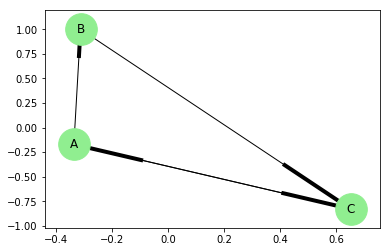

In [61]:
import matplotlib.pyplot as plt
nx.draw_networkx(G, node_color = 'lightgreen', node_size = 1000,arrows=True)
plt.savefig('pictures/graph_example.png')


In [62]:
from operator import add
sc = SparkContext.getOrCreate()

In [63]:
diretorio_base = os.path.join('data')
caminho_teste = os.path.join('web-Google-test.txt')
arquivo_teste = os.path.join(diretorio_base, caminho_teste)

In [64]:
def atualizaRank(listaUrls, rank):
    num_urls = len(listaUrls)
    rankAtualizado = []
    for x in listaUrls:
        rankAtualizado.append((x, (rank / num_urls)))
    return rankAtualizado

In [65]:
linksGoogle_teste = sc.textFile(arquivo_teste).filter(lambda x: "#" not in x).map(lambda x: x.split("\t"))

In [66]:
linksAgrupados_teste = linksGoogle_teste.groupByKey().cache()
#print(linksAgrupados.take(1))
#for it in linksAgrupados.take(1)[0][1]:
#  print(it)


In [31]:
ranks_teste = linksAgrupados_teste.map(lambda url_agrupados: (url_agrupados[0], 1.0))

In [32]:
for x in range(1,2):
    # Adiciona ranks inicializados com 1.0 na posição [1][1] da matriz
    agrupaIdLinkComRank_teste = linksAgrupados_teste .join(ranks_teste)\
                .flatMap(lambda url_rank: atualizaRank(url_rank[1][0], url_rank[1][1]))
    # Soma os valores com o mesmo id e adiciona o fator de normalização
    ranks_teste = agrupaIdLinkComRank_teste.reduceByKey(add)\
                                .mapValues(lambda rankFatorD: (rankFatorD * 0.85) + 0.15)


### Resultado do Teste:

In [33]:
for (link, rank) in ranks_teste.sortBy(lambda x:-x[1]).take(3):
    print("ID: %s  Ranking: %s." % (link, rank))

ID: C  Ranking: 1.4249999999999998.
ID: A  Ranking: 1.0.
ID: B  Ranking: 0.575.


## Aplicação do PageRank na Base da Dados Real (web-google.txt)
Após o teste, vamos aplicar o algoritmo de PageRank na base de dados de referências de páginas da web (arquivo web-Google.txt) encontrada no site da [Stanford](https://snap.stanford.edu/data/web-Google.html).

In [36]:
diretorio_base = os.path.join('data')
caminho = os.path.join('web-Google.txt')
arquivo = os.path.join(diretorio_base, caminho)

In [37]:
linksGoogle = sc.textFile(arquivo).filter(lambda x: "#" not in x).map(lambda x: x.split("\t"))

In [38]:
linksAgrupados = linksGoogle.groupByKey().partitionBy(100).cache()

In [39]:
ranks = linksAgrupados.map(lambda url_agrupados: (url_agrupados[0], 1.0))

In [40]:
for x in range(1,8):
    # Adiciona ranks inicializados com 1.0 na posição [1][1] da matriz
    agrupaIdLinkComRank = linksAgrupados.join(ranks)\
                .flatMap(lambda url_rank: atualizaRank(url_rank[1][0], url_rank[1][1]))
    # Soma os valores com o mesmo id e adiciona o fator de normalização
    ranks = agrupaIdLinkComRank.reduceByKey(add)\
                                .mapValues(lambda rankFatorD: (rankFatorD * 0.85) + 0.15)

### Resultado das 10 primeias páginas mais relevantes:

In [41]:
for (link, rank) in ranks.sortBy(lambda x:-x[1]).take(10):
    print("ID: %s  Ranking: %s." % (link, rank))

ID: 41909  Ranking: 484.1108170361068.
ID: 597621  Ranking: 443.91101174854504.
ID: 537039  Ranking: 422.4181650873821.
ID: 504140  Ranking: 422.35439939726194.
ID: 384666  Ranking: 419.29510039258287.
ID: 486980  Ranking: 415.0762289087505.
ID: 163075  Ranking: 398.2489263636541.
ID: 605856  Ranking: 386.1123031542763.
ID: 751384  Ranking: 385.3404836210412.
ID: 32163  Ranking: 384.2036138933663.
